In [32]:
# entire code is being run on an Ubuntu kernel. 
# not many QoL libraries are needed.
# your mileage may vary.
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# training specific imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

# dataset imports
import utils_ade20k
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Resize, ToPILImage, Lambda
import torchvision.transforms as transforms

# AI imports
import torch
import torch.nn as nn

# statistics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, roc_curve

# test if GPU acceleration is working
torch.cuda.is_available()

True

## This notebook will be used for creating the segmentation model based on the ADE20K dataset.

### Step 1. EDA

In [33]:
# load in the ade20k pickle file to examine it.
root = './ade20k/ADE20K_2021_17_01/'
with open(root + 'index_ade20k.pkl', 'rb') as f:
    index_ade20k = pickle.load(f)

In [34]:
# let's look at a basic description of the dataset
print("Dataset loaded, description of the attributes:\n--------------------------------------------")
for attr, desc in index_ade20k['description'].items():
    print('- {}: {}'.format(attr, desc))

Dataset loaded, description of the attributes:
--------------------------------------------
- filename: array of length N=27574 with the image file names
- folder: array of length N with the image folder names.
- scene: array of length N providing the scene name (same classes as the Places database) for each image.
- objectIsPart: array of size [C, N] counting how many times an object is a part in each image. objectIsPart[c,i]=m if in image i object class c is a part of another object m times. For objects, objectIsPart[c,i]=0, and for parts we will find: objectIsPart[c,i] = objectPresence(c,i)
- objectPresence: array of size [C, N] with the object counts per image. objectPresence(c,i)=n if in image i there are n instances of object class c.
- objectcounts: array of length C with the number of instances for each object class.
- objectnames: array of length C with the object class names.
- proportionClassIsPart: array of length C with the proportion of times that class c behaves as a par

In [89]:
# set a random index for visualization and experimentation.
idx = np.random.randint(0, 27574)
idx

24182

TypeError: object of type 'bool' has no len()

In [90]:
# using an included script to gather all data we need ot start segmentation
nfiles = len(index_ade20k['filename'])
file_name = index_ade20k['filename'][idx]
num_obj = index_ade20k['objectPresence'][:, idx].sum()
num_parts = index_ade20k['objectIsPart'][:, idx].sum()
count_obj = index_ade20k['objectPresence'][:, idx].max()
obj_id = np.where(index_ade20k['objectPresence'][:, idx] == count_obj)[0][0]
obj_name = index_ade20k['objectnames'][obj_id]
full_file_name = '{}/{}'.format(index_ade20k['folder'][idx], index_ade20k['filename'][idx])
print("The dataset has {} images".format(nfiles))
print("The image at index {} is {}".format(idx, file_name))
print("It is located at {}".format(full_file_name))
print("It happens in a {}".format(index_ade20k['scene'][idx]))
print("It has {} objects, of which {} are parts".format(num_obj, num_parts))
print("The most common object is object {} ({}), which appears {} times".format(obj_name, obj_id, count_obj))

The dataset has 27574 images
The image at index 24182 is ADE_train_00024183.jpg
It is located at ADE20K_2021_17_01/images/ADE/training/sports_and_leisure/racecourse/ADE_train_00024183.jpg
It happens in a racecourse
It has 11 objects, of which 0 are parts
The most common object is object person, individual, someone, somebody, mortal, soul (1830), which appears 4 times


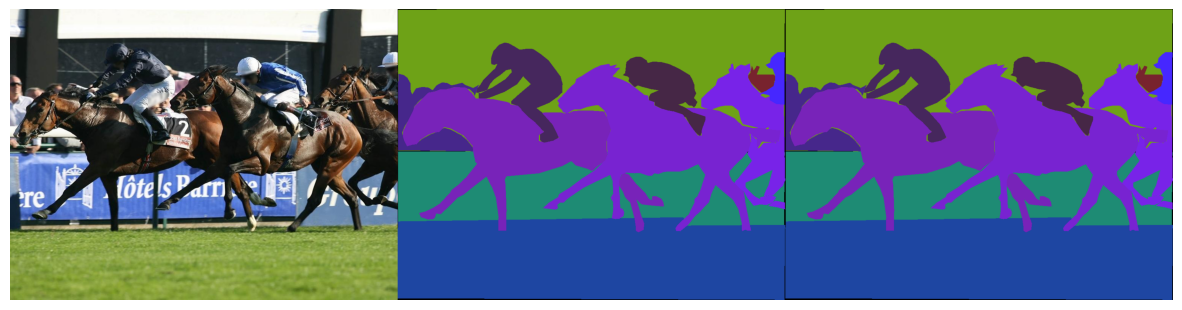

In [91]:
# This function reads the image and mask files and 
# generate instance and segmentation masks
info = utils_ade20k.loadAde20K('{}/{}'.format('./ade20k', full_file_name))
img = read_image(info['img_name'])
seg = read_image(info['segm_name'])
seg_mask = seg.detach().clone()

# The 0 index in seg_mask corresponds to background (not annotated) pixels
plt.figure(figsize=(15,5))

plt.imshow(np.transpose(np.concatenate([img, seg, seg_mask], 2), (1, 2, 0)))
plt.axis('off')
if len(info['partclass_mask']):
    plt.figure(figsize=(5*len(info['partclass_mask']), 5))
    plt.title('Parts')
    plt.imshow(np.concatenate(info['partclass_mask'],1))
    plt.axis('off')

In [ ]:
# create a loader for train and val seperately.
# i'm not sure how to use all of the files given here.
# FIXME

In [13]:
# rewrite custom config for dataset class and loaders
# Recreate a custom dataset class.
class SegmentationDataset(Dataset):
    def __init__(self, annotations, img_dir: str, transform=None, target_transform=None):
        """A custom dataset class created for the sentiment analysis portion of project Ayre.
        NOTE: Make sure the annotations entry is the loaded dataframe itself and NOT the filepath.
        This was done to smoothen our own training process.

        Args:
            annotations (pd.DataFrame): the Pandas DataFrame object of the annotations file
            img_dir (str): the root folder where all the images are kept
            transform (Image Transform, optional): a PyTorch Transform or Compose Object. Defaults to None.
            target_transform (Label Transform, optional): a PyTorch Transform or Compose Object. Defaults to None.
        """
        self.img_labels = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.target_names = self.img_labels.columns[1:]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1:]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, torch.tensor(label)

In [14]:
# initialize all dataset params
img_w = 512
img_h = 512
train_batch = 96
test_batch = 64

# creating a custom transform
preproc = transforms.Compose([
    ToPILImage(),
    Resize((img_h, img_w), antialias=True),
    Lambda(lambda img: img.convert('RGB')),
    ToTensor(),
])

In [ ]:
# create dataset objects
train_dataset = SegmentationDataset(train, root, transform=preproc)
test_dataset = SegmentationDataset(test, root, transform=preproc)

In [ ]:
# create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=True)